### Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn import base
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import *
import datetime

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Data Cleaning

### Loading the dataset

In [2]:
df_raw = pd.read_csv('time_series_covid19_confirmed_global.csv')
df_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,46516,46718,46837,46837,47072,47306,47516,47716,47851,48053
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,39014,39719,40501,41302,42148,42988,43683,44436,45188,46061
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,84152,85084,85927,86730,87502,88252,88825,89416,90014,90579
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,6790,6842,6904,6955,7005,7050,7084,7127,7162,7190
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15251,15319,15361,15493,15536,15591,15648,15729,15804,15925


### Selecting USA as Country for analysis purposes and modelling

In [3]:
df_USA = df_raw[df_raw['Country/Region'] == 'US']
df_USA.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
247,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,13721822,13921929,14139609,14367437,14581318,14756982,14949417,15165295,15386562,15611014


In [4]:
# Transposing the laoded dataset to arrange in date format for modelling purposes
df_covid=df_USA.transpose().iloc[4:]
df_covid.head()

,247
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5


In [5]:
# Extracting information 
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 1/22/20 to 12/10/20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   247     324 non-null    object
dtypes: object(1)
memory usage: 5.1+ KB


In [6]:
# Taking all the dates in index format
df_covid.index

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '12/1/20', '12/2/20', '12/3/20', '12/4/20', '12/5/20', '12/6/20',
       '12/7/20', '12/8/20', '12/9/20', '12/10/20'],
      dtype='object', length=324)

In [7]:
# Converting the index into dataframe
df_covid.index = pd.to_datetime(df_covid.index)
df_covid.head()

,247
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


## 2. Data Visualization and Exploratory Data Analysis

### Plotting the graph

Text(0, 0.5, 'Toal Number Of COVID-19 Cases')

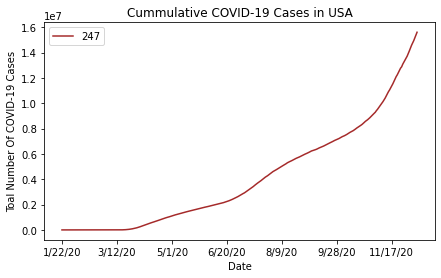

In [8]:
#Plotting the graph for the cummulative case wrt the time line of year 2020
ax=df_USA.transpose().iloc[4:].plot(kind='line',figsize=(7,4), title='Cummulative COVID-19 Cases in USA',color='brown')
ax.set_xlabel("Date")
ax.set_ylabel("Toal Number Of COVID-19 Cases")

#### EDA: Cummulative Rise of cases starting from January-2020 to December-2020

Text(0, 0.5, 'Daily Number Of COVID-19 Cases')

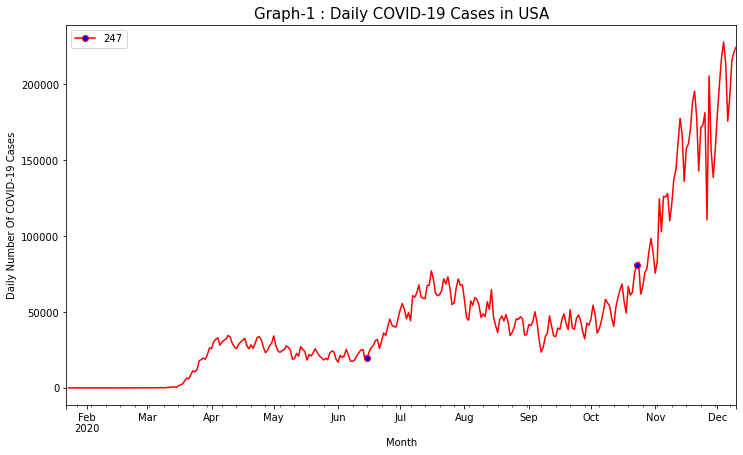

In [9]:
#Daily rise in COVID-19 cases across USA
yx=df_covid.diff(axis=0).plot(kind='line',figsize=(12,7),color='red',markevery=[145,275], marker='o', markerfacecolor='b')
yx.set_title("Graph-1 : Daily COVID-19 Cases in USA",fontsize=15)
yx.set_xlabel("Month",fontsize=10)
yx.set_ylabel("Daily Number Of COVID-19 Cases",fontsize=10)

#### EDA: Daily Rise in the COVID-19 cases across USA showing second wave of infection from November, 2020 onwards. The first wave ended approx by end of September, 2020.

- The two dots are representing the spike in the case number which starts from July and November.

Text(0, 0.5, 'Daily Number Of COVID-19 Cases')

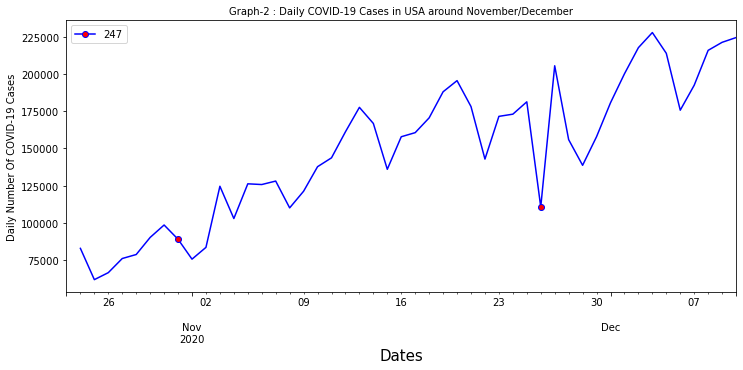

In [10]:
#Daily rise in COVID-19 cases across USA around the month of last october, november, early december
zx=df_covid.iloc[275:].diff(axis=0).plot(kind='line',figsize=(12,5),color='blue',markevery=[8,34], marker='o', markerfacecolor='r')

#markevery points (1) 31st october,2020=Halloween (2) 26th november,2020=THanksgiving

zx.set_title("Graph-2 : Daily COVID-19 Cases in USA around November/December",fontsize=10)
zx.set_xlabel("Dates",fontsize=15)
zx.set_ylabel("Daily Number Of COVID-19 Cases",fontsize=10)


#### EDA: 
- The selected model for projection will be aimed towards November and December, so expanding the trend data on these months. 
- The two red points (1) 31st October,2020 : Halloween (2) 26th November,2020 : Thanksgiving shows one of the reason for high increase of daily cases specifically after thanks giving due to more people gathering. It will be dsicussed in later part

### Decomposing Data into Components

Since the cummulative trend shows the exponential or say non linear nature of the cases, thus selecting model type as multiclative

In [11]:
multiclative = seasonal_decompose(df_covid, model='multiclative', extrapolate_trend='freq')

Text(0.5, 0.98, 'Graph-3 : Multiclative Decompose')

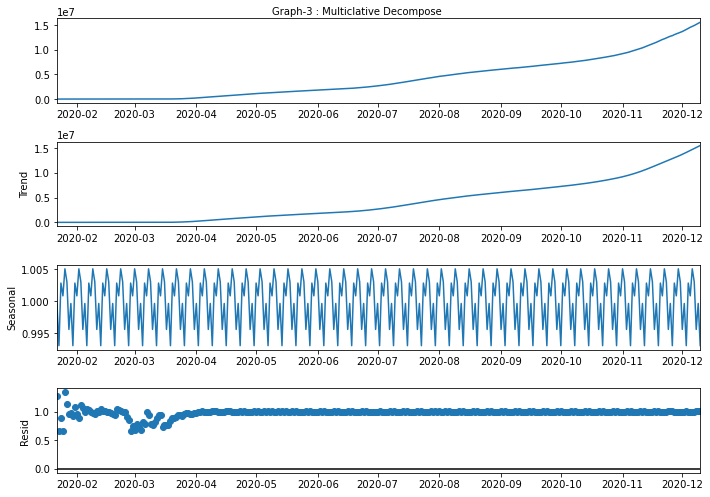

In [12]:
plt.rcParams.update({'figure.figsize': (10,7)})
multiclative.plot().suptitle('Graph-3 : Multiclative Decompose', fontsize=10)

#### Trend is increasing with time. Seasonal data is cyclic. Residual is pretty much constant. Thus, the decomposition of the data shows that model- ARIMA can be used for projecting the COVID-19 case.

In [13]:
# Just the tabular form of the different values
multiclative_df = pd.concat([multiclative.seasonal, multiclative.trend, multiclative.resid, multiclative.observed], axis=1)
multiclative_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
multiclative_df.head()

,seasonal,trend,resid,actual_values
2020-01-22,0.999641,0.785714,1.273185,1.0
2020-01-23,0.993084,1.525510,0.660083,1.0
2020-01-24,1.002812,2.265306,0.880407,2.0
2020-01-25,1.000828,3.000000,0.666115,2.0
2020-01-26,1.005023,3.714286,1.339426,5.0


## 3. Model Selection - ARIMA

ARIMA, stands for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

Text(0, 0.5, 'Number of Cases')

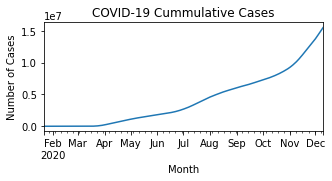

In [14]:
#Assigning the value of trend and plotting just a graph
trend = multiclative.trend

ax = trend.plot(figsize=(5,2), title='COVID-19 Cummulative Cases')
ax.set_xlabel("Month")
ax.set_ylabel("Number of Cases")

#### Deciding the order of differencing
- Need to check if data/series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
- The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then reject the null hypothesis and infer that the time series is indeed stationary

In [15]:
from statsmodels.tsa.stattools import adfuller # Importing adfuller 

In [16]:
result = adfuller(trend.values, regression='nc')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.874782
p-value: 0.999633


- p-value is greater than the significance level, so differencing the series and to observe autocorrelation plot.

Text(0.5, 0.98, '2nd Order Differencing')

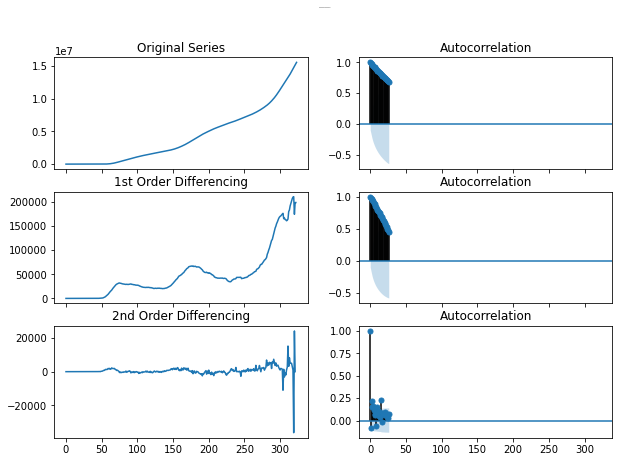

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Importing the required library

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(trend.values); axes[0, 0].set_title('Original Series')
plot_acf(trend.values, ax=axes[0, 1]).suptitle('Original Series', fontsize=0)

# 1st Differencing/ Plotting 1st differencing 
diff1 = trend.diff().dropna()
axes[1, 0].plot(diff1.values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff1.values, ax=axes[1, 1]).suptitle('1st Order Differencing', fontsize=0)

# 2nd Differencing/ PLotting 2nd differencing
diff2 = trend.diff().diff().dropna()
axes[2, 0].plot(diff2.values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(diff2.values, ax=axes[2, 1]).suptitle('2nd Order Differencing', fontsize=0)

#### For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the negative zone fairly , which indicates, the series might have been over differenced.
- Thus, going to tentatively fix the order of differencing as 2 even though the series is not perfectly stationary.

Text(0.5, 0.98, '2nd Order Differencing')

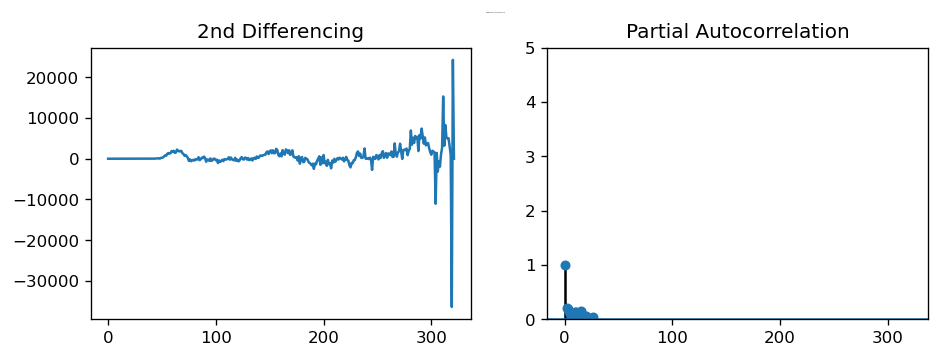

In [18]:
# Executing the partial autocoorelation to decide the d value of the ARIMA model

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff2.values)
axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff2.values, ax=axes[1]).suptitle('2nd Order Differencing', fontsize=0)

#### Thus, through Partial Autocorrelation, it looks like the differencing value equals 2. So, d=2 for ARIMA

### ACF and PACF
- ACF to find q for MA
- PACF to find p for AR

PACF- Partial autocorrelation is the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series.

Text(0.5, 0.98, '1st Order Differencing')

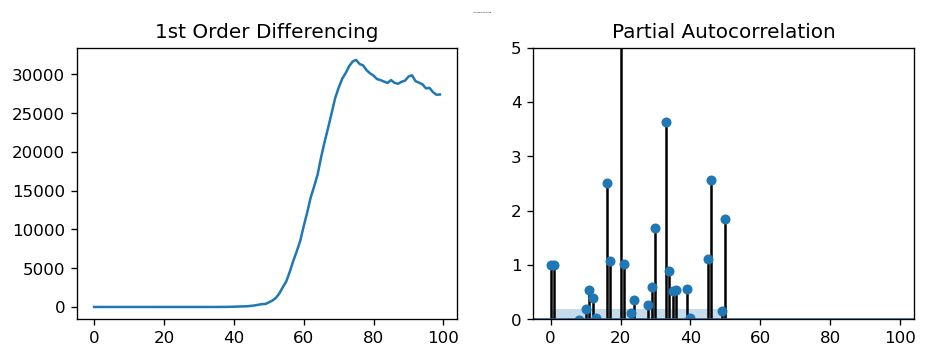

In [19]:
#Plotting the graph for the partial autocorrelation to find out the optimum 'p' value for AR

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
size=100
axes[0].plot(diff1.values[:size]) # for 1st differencing
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0) #for 1st differencing

- PACF lag 1 is quite significant since the former is well above the significance line (blue region) referring Partial Autocorrelation plot. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). For now considering p as 1

Text(0.5, 0.98, '1st Order Differencing')

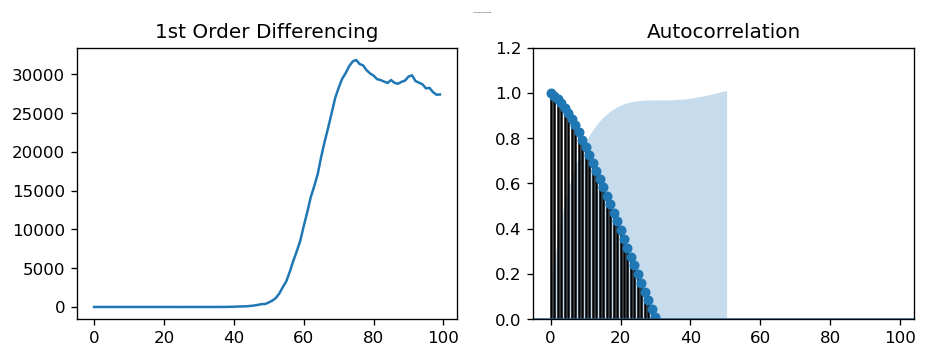

In [20]:
#Plotting the graph for the autocorrelation to find out the optimum 'q' value for MR

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1.values[:size]) # For 1st differencing 
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0) # for 1st differencing

- Couple of lags are well above the significance line. So, let’s tentatively fix q as 2.

### Best Case Projection

Considering the prevoius p,d,q value obtained as p=1,d=2,q=2 for ARIMA modelling parameters

In [21]:
from statsmodels.tsa.arima_model import ARIMA #Importing the required library

#Splitting the dataset into train and test

train1 = trend[:150] #out of 324 
test1  = trend[150:]

#Creating model
model1 = ARIMA(train1, order=(1,2,2))  # Considering the prevoius p,d,q value obtained as p=1,d=2,q=2
model1 = model1.fit(disp=0)  # Fitting the model
print(model1.summary()) # Printing the summary for the model created

                             ARIMA Model Results                              
Dep. Variable:               D2.trend   No. Observations:                  148
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1046.585
Method:                       css-mle   S.D. of innovations            283.179
Date:                Fri, 18 Dec 2020   AIC                           2103.169
Time:                        16:31:05   BIC                           2118.155
Sample:                    01-24-2020   HQIC                          2109.258
                         - 06-19-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            295.8133    298.825      0.990      0.322    -289.873     881.500
ar.L1.D2.trend     0.9485      0.029     33.197      0.000       0.892       1.005
ma.L1.D2.trend    -0.4685      0.093

### Since, the p values are smaller than the 0.05 Conf, which is great. Considering the most precise model 

In [22]:
#creating the model1 residual dataframe 
residuals1 = pd.DataFrame(model1.resid) 
residuals1.head()

,0
2020-01-24,-295.813313
2020-01-25,-35.420596
2020-01-26,-20.312062
2020-01-27,-19.076375
2020-01-28,-20.004170


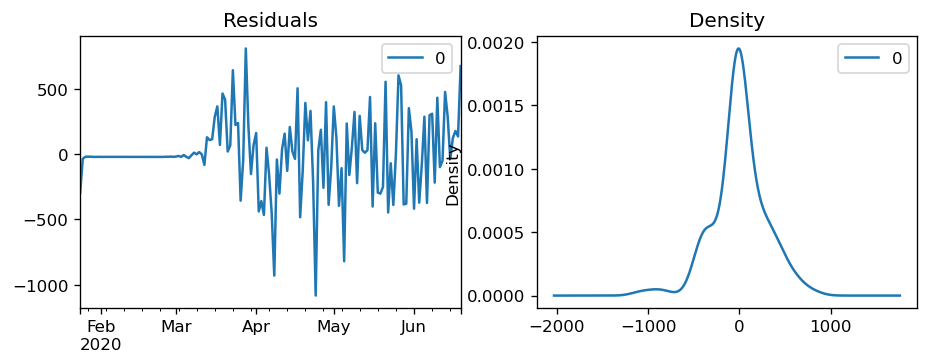

In [23]:
# Plot residual errors
fig, ax = plt.subplots(1,2)
residuals1.plot(title="Residuals", ax=ax[0])
residuals1.plot(kind='kde', title='Density', ax=ax[1])

#### The residual errors seems fine with near zero mean and uniform variance.

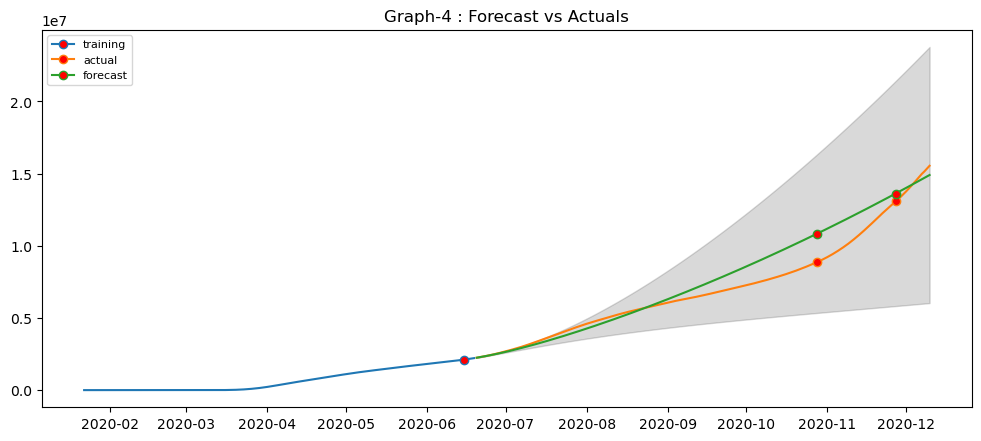

In [24]:
# Projecting the model for testing data
fc, se, conf = model1.forecast(174, alpha=0.05)  # 174 testing samples with 95% confidence

# Make as pandas series
fc_series1 = pd.Series(fc, index=test1.index) #for the forcast data
lower_series1 = pd.Series(conf[:, 0], index=test1.index) #for the lower conf level
upper_series1 = pd.Series(conf[:, 1], index=test1.index) #for the upper conf level

# Plot the graph for training, actual and forcast value
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train1, label='training',markevery=[145], marker='o', markerfacecolor='r')
plt.plot(test1, label='actual',markevery=[130,160], marker='o', markerfacecolor='r')
plt.plot(fc_series1, label='forecast',markevery=[130,160], marker='o', markerfacecolor='r')
plt.fill_between(lower_series1.index, lower_series1, upper_series1, 
                 color='k', alpha=.15)
plt.title('Graph-4 : Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

### The projection is quite accurate and all the projection data comes under 95% conf band, thus considering the best projection for the selected model.

- The red marker points around the month November & December will be discussed in later section 

### Intermediate Case Projection

Creating the model with p=2,d=1,q=1 as a little twiking to see the behaviour of the projection

In [25]:
train2 = trend[:150] #Splitting the data into test and training 
test2  = trend[150:]

#Creating model with p=2,d=1,q=1
model2 = ARIMA(train2, order=(2,1,1))  
model2 = model2.fit(disp=0)  #fitting the model
print(model2.summary()) #Printing the summary of the model created

                             ARIMA Model Results                              
Dep. Variable:                D.trend   No. Observations:                  149
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1059.831
Method:                       css-mle   S.D. of innovations            287.170
Date:                Fri, 18 Dec 2020   AIC                           2129.662
Time:                        16:31:06   BIC                           2144.682
Sample:                    01-23-2020   HQIC                          2135.764
                         - 06-19-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.35e+04   1.32e+04      1.785      0.074   -2297.008    4.93e+04
ar.L1.D.trend     1.9638      0.021     92.414      0.000       1.922       2.005
ar.L2.D.trend    -0.9654      0.021    -

#### Considering the intermediate model for projection as the AIC value is little more than the previou set of p,d,q paramters. Less AIC value corresponds more precision, in this case AIC for model2 is 2129 > AIC for model 1 that is 2103.

In [26]:
# Creating the model2 residual dataframe
residuals2 = pd.DataFrame(model2.resid)
residuals2.head()

,0
2020-01-23,-23502.227347
2020-01-24,-20.471375
2020-01-25,-38.997875
2020-01-26,-50.817161
2020-01-27,-56.454611


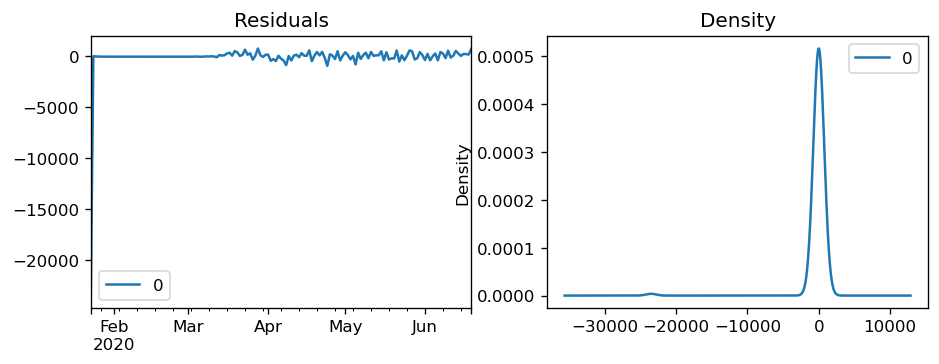

In [27]:
# Plot residual errors
fig, ax = plt.subplots(1,2)
residuals2.plot(title="Residuals", ax=ax[0])
residuals2.plot(kind='kde', title='Density', ax=ax[1])

#### Residual values looks great across 0.

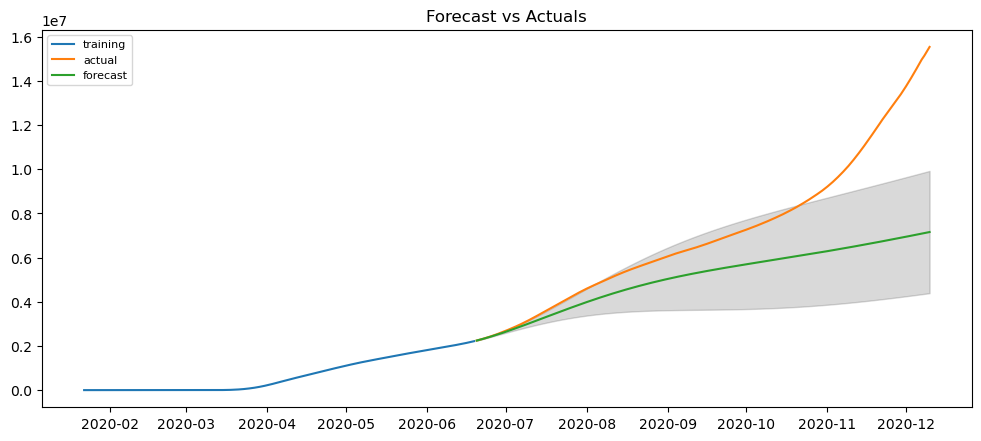

In [28]:
# Project the model for testing samples
fc, se, conf = model2.forecast(174, alpha=0.05)  # 174 testing samples, 95% conf

# Make as pandas series
fc_series2 = pd.Series(fc, index=test2.index) #for the forcast data
lower_series2 = pd.Series(conf[:, 0], index=test2.index) #for the lower conf level
upper_series2 = pd.Series(conf[:, 1], index=test2.index) #for the upper conf level

# Plot the graph for training, actual and forcast value
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train2, label='training')
plt.plot(test2, label='actual')
plt.plot(fc_series2, label='forecast')
plt.fill_between(lower_series2.index, lower_series2, upper_series2, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

### The projection till November looks great as in lie around 95% conf band but after that it is way over the band thus comparing with model1, it comes next or we can say intermediate projection model.

### Worst Case Projection

Creating the model with p=1,d=1,q=1 as a little twiking to see the behaviour of the projection

In [29]:
train3 = trend[:150] #Splitting the data into test and training 
test3  = trend[150:]

#Creating model with p=1,d=1,q=1
model3 = ARIMA(train3, order=(1,1,1))  
model3 = model3.fit(disp=0) #fitting the model
print(model3.summary()) #Printing the summary of the model created

                             ARIMA Model Results                              
Dep. Variable:                D.trend   No. Observations:                  149
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1134.212
Method:                       css-mle   S.D. of innovations            472.738
Date:                Fri, 18 Dec 2020   AIC                           2276.424
Time:                        16:31:07   BIC                           2288.440
Sample:                    01-23-2020   HQIC                          2281.306
                         - 06-19-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.619e+04        nan        nan        nan         nan         nan
ar.L1.D.trend     0.9999        nan        nan        nan         nan         nan
ma.L1.D.trend     0.6453      0.046     

#### AIC value for model 3 is 2276> AIC value for model 2 which is 2129, thus making it the worst projected model with the defined p,d,q parameters.

In [30]:
# Creating the model3 residual dataframe
residuals3 = pd.DataFrame(model3.resid)
residuals3.head()

,0
2020-01-23,-76187.404099
2020-01-24,-3.003946
2020-01-25,-4.377569
2020-01-26,-3.244722
2020-01-27,-3.738211


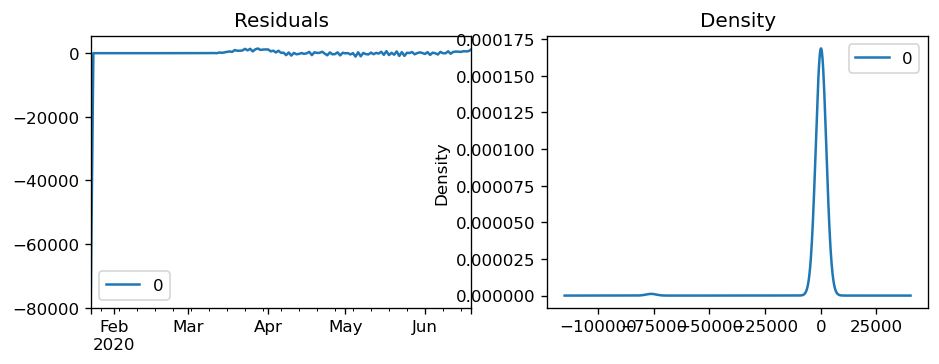

In [31]:
# Plot residual errors
fig, ax = plt.subplots(1,2)
residuals3.plot(title="Residuals", ax=ax[0])
residuals3.plot(kind='kde', title='Density', ax=ax[1])

#### Residuals looks great in this parameters too across 0!

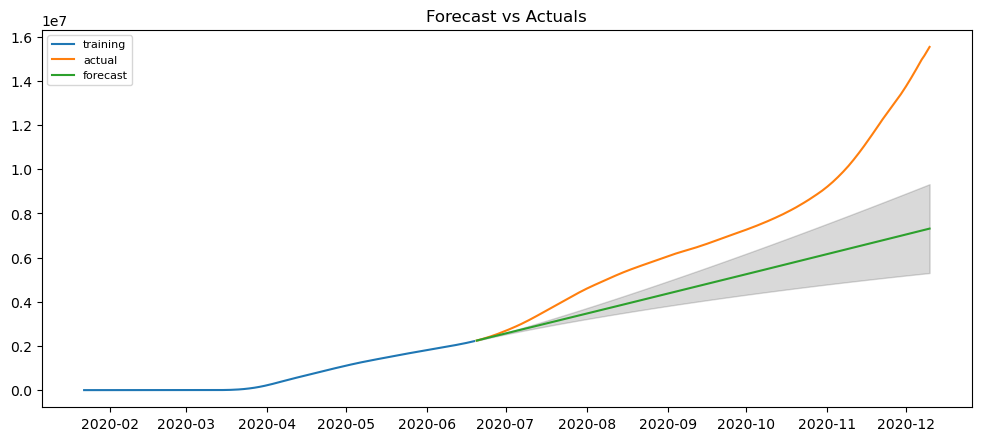

In [32]:
# Project the model for testing samples
fc, se, conf = model3.forecast(174, alpha=0.05)  # 174 testing samples, 95% conf

# Make as pandas series
fc_series3 = pd.Series(fc, index=test3.index) #for the forcast data
lower_series3 = pd.Series(conf[:, 0], index=test3.index) #for the lower conf level
upper_series3 = pd.Series(conf[:, 1], index=test3.index) #for the upper conf level

# Plot the graph for training, actual and forcast value
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train3, label='training')
plt.plot(test3, label='actual')
plt.plot(fc_series3, label='forecast')
plt.fill_between(lower_series3.index, lower_series3, upper_series3, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

### The projected data for the COVID-19 cases in this model looks horrible as it does not even fit under 95% conf band. Thus, considering this model 3 as the worst created model with the certain model parameters.

## 4. Relating COVID-19 Projections to a Second Dataset

### Loading the other dataset 

In [33]:
df_set2=pd.read_csv('data-1.csv')
df_set2.head()

,id,date,tests,confirmed,recovered,deaths,hosp,vent,icu,population,...,currency,administrative_area_level,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,latitude,longitude,key,key_apple_mobility,key_google_mobility
0,AFG,1/1/20,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
1,AFG,1/2/20,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
2,AFG,1/3/20,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
3,AFG,1/4/20,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
4,AFG,1/5/20,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF


#### Selecting USA for relating the finding from the Part-2 and Part-3

In [34]:
df_USA_set2=df_set2[df_set2['id']=='USA']
df_USA_set2.head()

,id,date,tests,confirmed,recovered,deaths,hosp,vent,icu,population,...,currency,administrative_area_level,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,latitude,longitude,key,key_apple_mobility,key_google_mobility
64170,USA,1/1/20,0,0,0,0,0,0,0,326687501,...,USN,1,United States,NaN,NaN,38.0,-97.0,NaN,United States,US
64171,USA,1/2/20,0,0,0,0,0,0,0,326687501,...,USN,1,United States,NaN,NaN,38.0,-97.0,NaN,United States,US
64172,USA,1/3/20,0,0,0,0,0,0,0,326687501,...,USN,1,United States,NaN,NaN,38.0,-97.0,NaN,United States,US
64173,USA,1/4/20,0,0,0,0,0,0,0,326687501,...,USN,1,United States,NaN,NaN,38.0,-97.0,NaN,United States,US
64174,USA,1/5/20,0,0,0,0,0,0,0,326687501,...,USN,1,United States,NaN,NaN,38.0,-97.0,NaN,United States,US


In [35]:
# Selecting some restrictons/lockdowns columns from the US dataset
df_USA_res=df_USA_set2[['date','gatherings_restrictions','stay_home_restrictions','internal_movement_restrictions','transport_closing']]
df_USA_res.tail()

,date,gatherings_restrictions,stay_home_restrictions,internal_movement_restrictions,transport_closing
64510,12/6/20,4,2,2,1
64511,12/7/20,4,2,2,1
64512,12/8/20,4,2,2,1
64513,12/9/20,4,2,2,1
64514,12/10/20,4,2,2,1


In [36]:
df_USA_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 64170 to 64514
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   date                            345 non-null    object
 1   gatherings_restrictions         345 non-null    int64 
 2   stay_home_restrictions          345 non-null    int64 
 3   internal_movement_restrictions  345 non-null    int64 
 4   transport_closing               345 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 16.2+ KB


Text(0, 0.5, 'Restriction Level')

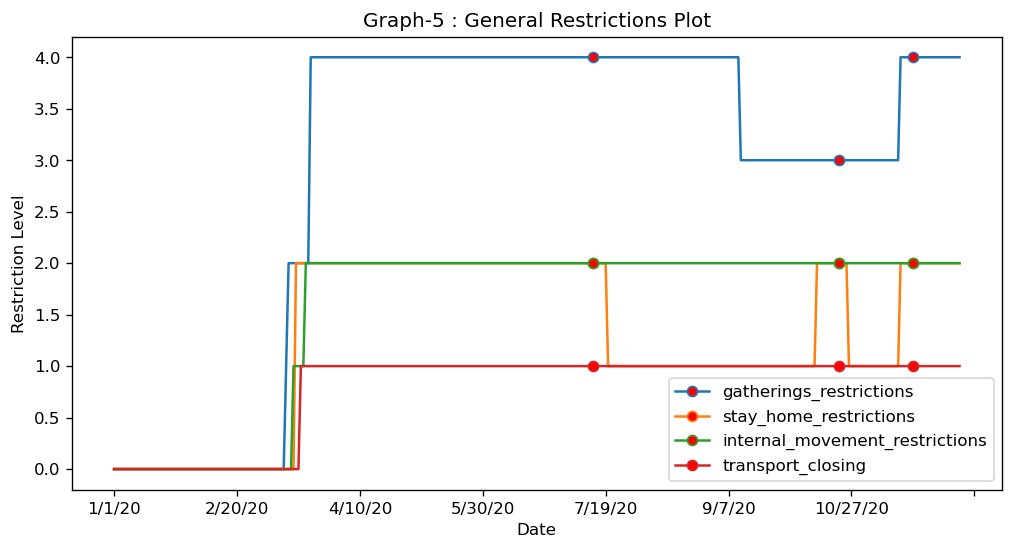

In [37]:
#Plotting graph with the restrictions/lockdowns
ax = df_USA_res.plot(x='date',figsize=(10,5), title='Graph-5 : General Restrictions Plot',markevery=[195,295,325], marker='o', markerfacecolor='r')
ax.set_xlabel("Date")
ax.set_ylabel("Restriction Level")


- The three red marker on the graphs for various restrictions referred to the starting of major spikes in increase of the COVID-19 cases across USA. 
- Referring to Graph-1 and Graph-4, during late October and November, there is sudden increase in the number of cases and the reason we can see on the Graph-5, as the restriction level for the gathering were decreased during these period.
-  Stay home restrictions were also going down during November, which is also contributing the rise in cases.
- Further the month of July,late October and late November are being considered in account because of the holiday seasons as in July, independance day celebraion, October-Halloween and November-Thanks giving.
- Above factors make sense for the high rise of cases during or after these months.

In [38]:
# Similarly selecting columns regarding the closinf of the institutions
df_USA_close=df_USA_set2[['date','school_closing','workplace_closing','cancel_events']]
df_USA_close.head()

,date,school_closing,workplace_closing,cancel_events
64170,1/1/20,0,0,0
64171,1/2/20,0,0,0
64172,1/3/20,0,0,0
64173,1/4/20,0,0,0
64174,1/5/20,0,0,0


Text(0, 0.5, 'Restriction Level')

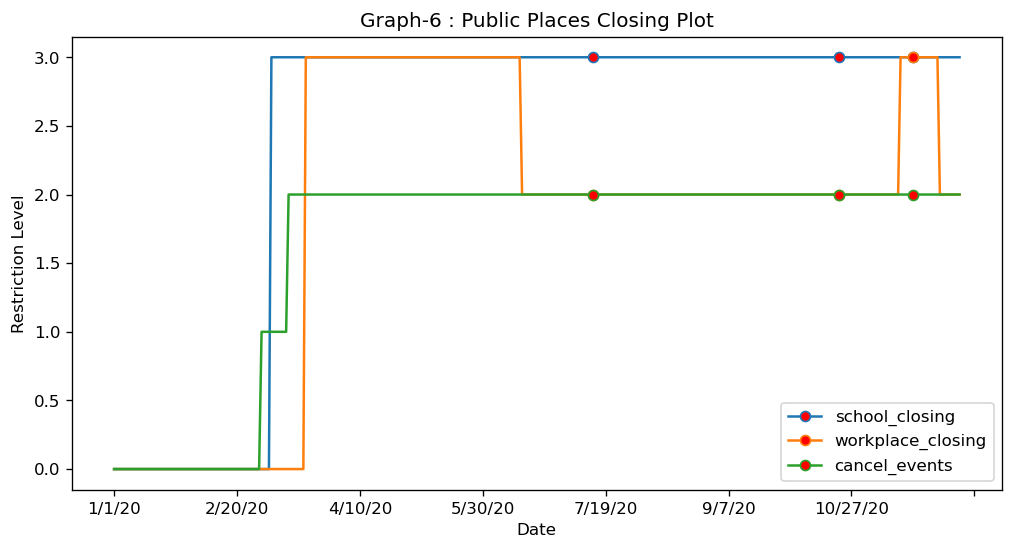

In [39]:
# Plotting graph
ax1 = df_USA_close.plot(x='date',figsize=(10,5), title='Graph-6 : Public Places Closing Plot',markevery=[195,295,325], marker='o', markerfacecolor='r')
ax1.set_xlabel("Date")
ax1.set_ylabel("Restriction Level")

- Workplace closing restriction level has been decrease to level-2 in between June, and it can be seen during early July, there is sudden increase in cases.
- Beside, workplace closing restiction level is again went down to level-2 after end of November and there is huge rise in cases in early December. Refer Graph-4

In [40]:
# Selecting column for the deaths and the recovery in US
df_USA_hos=df_USA_set2[['date','recovered','deaths']]
df_USA_hos.tail()

,date,recovered,deaths
64510,12/6/20,5624444,282299
64511,12/7/20,5714557,283703
64512,12/8/20,5786915,286249
64513,12/9/20,5889896,289373
64514,12/10/20,5985047,292141


Text(0, 0.5, 'Total Number')

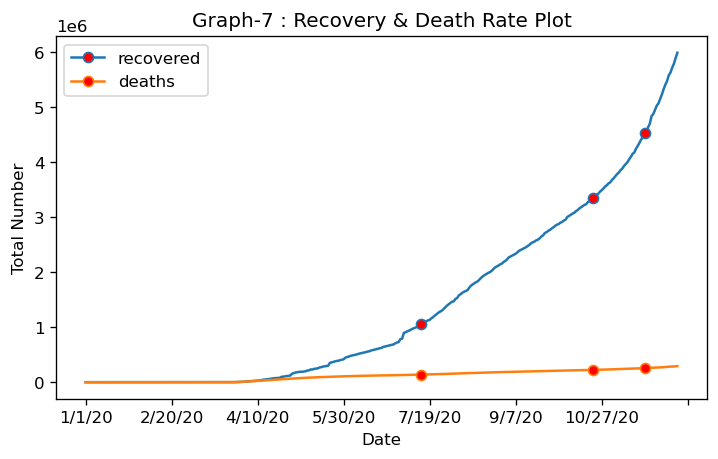

In [41]:
#PLotting the graph
ax2 = df_USA_hos.plot(x='date',figsize=(7,4), title='Graph-7 : Recovery & Death Rate Plot',markevery=[195,295,325], marker='o', markerfacecolor='r')
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Number")

- The recovery rate is huge as comparison to death rate, so there is misconception across the people that the COVID-19 virus is not deadly at all.
- Taking too lightly is one of the main concerns and leading cause of the spread of the virus. People having pshycological effect that they will be going to recover without any scientific evidence, thus neglecting the contagoiusness of the virus and making everybody affected while puttng more strain on the medical services.

In [42]:
# Selecting column for the stringency index in US
df_USA_str=df_USA_set2[["date",'stringency_index']]
df_USA_str.head()

,date,stringency_index
64170,1/1/20,0.0
64171,1/2/20,0.0
64172,1/3/20,0.0
64173,1/4/20,0.0
64174,1/5/20,0.0


Text(0, 0.5, 'Stringency Magnitude')

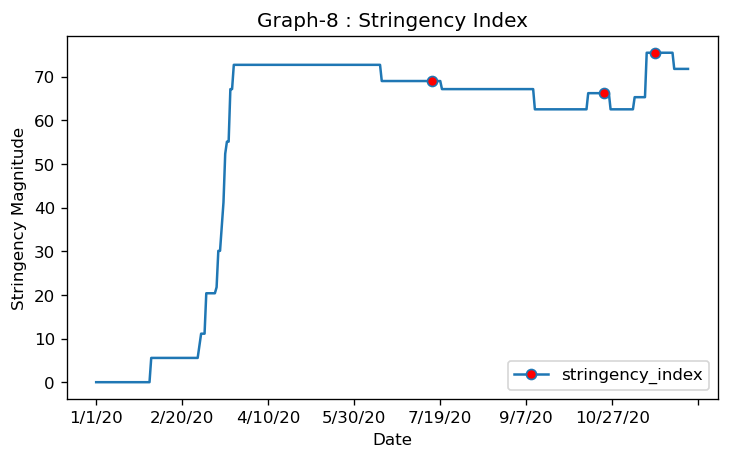

In [43]:
#PLotting the graph
ax3 = df_USA_str.plot(x='date',figsize=(7,4), title='Graph-8 : Stringency Index',markevery=[195,295,325], marker='o', markerfacecolor='r')
ax3.set_xlabel("Date")
ax3.set_ylabel("Stringency Magnitude")

- Stringency Index is the level of strictness controlled by government to control the pandemic spread.
- Three dots or marker are being referred as July, late October and late November, from where the cases are spiking up.
- After June, the index went down and down till October end and suddenly after the starting of the second wave from late November, it went up.
- Many countries have the index over 95% during first wave itself but USA after being badly hit by the second wave, the index is still approx 75%.

## 5. Deriving insights about policy and guidance to tackle the outbreak based on model findings.

### 1. Referring Graph-4 for the Forecast & Actual cases, the red marker around October end, shows the difference in actual and forecast value. The forecast value is showing more than the actual one. Under such scenario, the policy that government should follow is to decrease the restrictions as well as stringency magnitude which can easily be reflected on Graph-5  & 8.

### 2. Referring Graph-4 for the Forecast & Actual cases, the red marker around November end, shows the approximately same values for the cases. Under such circumstances, the policy that government should follow is to keep the same level of the restriction and observe for another 7-14 days period after that. If there is decrease in number of cases then decrease the restriction level after some 7 days time.

### 3. If in case the forecast value is showing less than the actual one, then increase the restriction level from immediate effect by increasing the stringency index.

## Potential Guidance to Control the Pandemic Situation

### For USA or any other country Government :
#### 1. Increase the stringency index as soon as possible to approx 95% level. This will ensure less pressure on the medical services.
#### 2. Increase the lockdowns/restriction in working areas. Focus more on the work from home culture as new guidelines for people.
#### 3. Hold down the internal mode of transportation like flights or metro for 2-3 days period to break the spread cycle.
#### 4. Impose stay at home orders in the heavily affected areas from COVID-19.

### For General Public
#### 1. Avoid social gathering irrespective of the holiday seasons. 
#### 2. COVID-19 is a deadly virus and still we dont know the exact reasons why it is affecting one person and not the other one. So the recovery rate should not be manipulated in wrong direction and people should take precaution like wearing mask and avoid gatherings.